In [1]:
import numpy as np
import tensorflow as tf
from ndllab.hiragana4 import HiraganaDataset
from ndllab.net1 import network

In [2]:
# -----------------------------------------------------------------------------------------
# バッチ学習において、学習回数は一般的に エポック(epoch) と ステップ(step) に分けて定義する。
# エポックは、トレーニングセット1回分の反復を表す。
# ステップは1エポック中にバッチ学習を行う回数で、その最大値は次の式で決まる値である。
# 　　　　ステップ数の最大値=floor(トレーニング画像数/バッチサイズ)
# -----------------------------------------------------------------------------------------

In [3]:
# パラメーター
# バッチサイズ
BATCH_SIZE = 32
# 学習回数
NUM_EPOCHS = 5
NUM_STEPS = 1000
# 学習中の出力頻度
OUTPUT_BY_STEPS = 500
# 学習率の初期値
LEARNING_RATE = 1e-4
#ドロップアウト率
DROPOUT_PROB_1 = 0.5
DROPOUT_PROB_2 = 0.5

In [4]:
# 再現性の確保のために乱数シードを固定
np.random.seed(12345)

# 平仮名データセットのワンホット表現での読み込み
dataset = HiraganaDataset(one_hot=True, validation_size=0.2)

In [5]:
# グラフの定義：1つのネットワークモデルを表す。
# プログラム中で異なるネットワークモデルを複数利用するなら、グラフをその数だけ作成する。
g = tf.Graph()
with g.as_default():
    # 再現性の確保のために乱数シードを固定（数値は何でもよい）
    tf.set_random_seed(12345)
    # 入力
    x = tf.placeholder(tf.float32, name='images', shape=(None, 48, 48, 3))
    p_1 = tf.placeholder(tf.float32, name='p_1')
    p_2 = tf.placeholder(tf.float32, name='p_2')
    labels = tf.placeholder(tf.float32, name='labels', shape=(None, dataset.n_classes))
    
    # 出力 (softmax)
    y = network(x, p_1, p_2)

    # 損失関数（交差エントロピー）と最適化処理（Adam）
    # log の項には計算上の問題を回避するため、正の小さな値1e-9を用いている。
    loss = -tf.reduce_sum(labels * tf.log(y + 1e-9)) / tf.cast(tf.shape(y)[0], tf.float32)

    # 1エポックごとに学習率を小さくする
    # 通常学習率はトレーニングが進むにつれて、指数減衰や段階的な減衰(step decay)により徐々に減らしていく。
    # トレーニング開始時は重みやバイアスが大きく更新され、トレーニングが進むと更新量が小さくなっていく。
    # このように更新することで、トレーニングが効率よく進むことが期待できる。
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(
        learning_rate=LEARNING_RATE, decay_rate=0.5, decay_steps=NUM_STEPS, global_step=global_step)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    # 精度検証 (Top-1 accuracy)
    prediction_match = tf.equal(tf.argmax(y, axis=1), tf.argmax(labels, axis=1))
    accuracy = tf.reduce_mean(tf.cast(prediction_match, tf.float32), name='accuracy')



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
# セッション：グラフの実行単位 sess.run()とx.eval()を呼び出すことで実際の計算が行われる。
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    dropout_prob = {p_1: DROPOUT_PROB_1, p_2: DROPOUT_PROB_2}

    saver = tf.train.Saver()
    step = 0

    # データセット全体を NUM_EPOCHS 回学習する
    for epoch in range(NUM_EPOCHS):
        batch_iter = dataset.train.next_batch(BATCH_SIZE)

        # イテレータを NUM_STEPS 回呼び出す
        for _ in range(NUM_STEPS):
            batch = next(batch_iter)
            # 正規化(0~1の範囲に収まる最大最小正規化)
            normalized_batch = batch[0] / 255.0
            # バッチ学習
            optimizer.run(feed_dict={x: normalized_batch, labels: batch[1], **dropout_prob})
            
            # コンソールへの出力
            if step % OUTPUT_BY_STEPS == 0:
                train_loss, train_accuracy = sess.run([loss, accuracy], 
                    feed_dict={x: normalized_batch, labels: batch[1], p_1: 1.0, p_2: 1.0})
                
                val_images, val_labels = dataset.val.images / 255.0, dataset.val.labels
                val_loss, val_accuracy = sess.run([loss, accuracy],
                    feed_dict={x: val_images, labels: val_labels, p_1: 1.0, p_2: 1.0})
                print('epoch {:d}, step {:d}, loss {:.2f}, accuracy {:.2f}, val_loss {:.2f}, val_accuracy {:.2f}'.format(
                    epoch, step, train_loss, train_accuracy, val_loss, val_accuracy))
            
                # 過程の保存
                saver.save(sess, 'models/hiragana', global_step=step)
                
            # ステップ数を更新
            step += 1
    
    # 最終結果の保存
    saver.save(sess, 'models/hiragana')

epoch 0, step 0, loss 4.29, accuracy 0.09, val_loss 4.29, val_accuracy 0.01
epoch 0, step 500, loss 4.24, accuracy 0.00, val_loss 4.24, val_accuracy 0.03
epoch 1, step 1000, loss 1.50, accuracy 0.78, val_loss 1.60, val_accuracy 0.68
epoch 1, step 1500, loss 0.82, accuracy 0.84, val_loss 0.74, val_accuracy 0.84
epoch 2, step 2000, loss 0.46, accuracy 0.91, val_loss 0.50, val_accuracy 0.88
epoch 2, step 2500, loss 0.18, accuracy 1.00, val_loss 0.39, val_accuracy 0.92
Instructions for updating:
Use standard file APIs to delete files with this prefix.
epoch 3, step 3000, loss 0.36, accuracy 0.91, val_loss 0.32, val_accuracy 0.93
epoch 3, step 3500, loss 0.26, accuracy 0.94, val_loss 0.28, val_accuracy 0.94
epoch 4, step 4000, loss 0.18, accuracy 0.97, val_loss 0.25, val_accuracy 0.95
epoch 4, step 4500, loss 0.13, accuracy 0.97, val_loss 0.23, val_accuracy 0.95


INFO:tensorflow:Restoring parameters from models/hiragana
test accuracy 0.95
char: ぴ, acc: 0.000000, correct: 00 of 21
char: ぷ, acc: 0.000000, correct: 00 of 26
char: ぺ, acc: 0.000000, correct: 00 of 53
char: ぽ, acc: 0.020000, correct: 01 of 50
char: ぱ, acc: 0.265625, correct: 17 of 64
char: ば, acc: 0.855814, correct: 184 of 215
char: ぼ, acc: 0.856459, correct: 179 of 209
char: は, acc: 0.874564, correct: 251 of 287
char: ざ, acc: 0.891753, correct: 173 of 194
char: ず, acc: 0.895238, correct: 188 of 210
char: て, acc: 0.920000, correct: 207 of 225
char: る, acc: 0.928270, correct: 220 of 237
char: な, acc: 0.932331, correct: 248 of 266
char: げ, acc: 0.939252, correct: 201 of 214
char: れ, acc: 0.944223, correct: 237 of 251


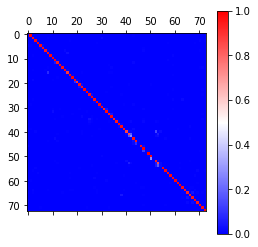

In [7]:
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 推論の実行

# モデルを指定
model_name = "models/hiragana"

# データフローグラフからプレースホルダーと精度測定処理ノードを取得
g = tf.Graph()
with g.as_default():
    # モデルの読み込み
    saver = tf.train.import_meta_graph('{}.meta'.format(model_name))

    x = g.get_tensor_by_name('images:0')
    labels = g.get_tensor_by_name('labels:0')
    p_1 = g.get_tensor_by_name('p_1:0')
    p_2 = g.get_tensor_by_name('p_2:0')
    y = g.get_tensor_by_name('y:0')
    accuracy = g.get_tensor_by_name('accuracy:0')

# 平仮名データセットのワンホット表現での読み込み
dataset = HiraganaDataset(one_hot=True, validation_size=0.2)

with tf.Session(graph=g) as sess:
    # 変数初期化
    sess.run(tf.global_variables_initializer())

    # モデル読み込み
    saver.restore(sess, model_name)

    # テストデータによる精度検証
    test_y, test_accuracy = sess.run([y, accuracy], 
        feed_dict={x: dataset.test.images, labels: dataset.test.labels, p_1: 1.0, p_2: 1.0})
    print('test accuracy {:.2f}'.format(test_accuracy))
    
    # 混同行列を作成
    y_true = np.argmax(dataset.test.labels, axis=1)
    y_pred = np.argmax(test_y, axis=1)
    test_confusion_matrix = confusion_matrix(y_true, y_pred)

    # クラスごとの要素数で割ることで、クラスごとの精度を計算する
    normalized_cm = test_confusion_matrix.astype(np.float32) / test_confusion_matrix.sum(axis=1)
    worst_index = np.argsort(normalized_cm.diagonal())

    # ラベルごとの精度、ラベル名、正解数、全数を取得
    worst_accuracy = normalized_cm.diagonal()[worst_index]
    worst_character = [dataset.get_character(i) for i in worst_index]
    worst_count = test_confusion_matrix.diagonal()[worst_index]
    worst_size = test_confusion_matrix.sum(axis=1)[worst_index]

    # 下位15ラベルを表示：ラベルのうち分類頻度が低い15個を精度とともに表示
    for accuracy, character, count, size in itertools.islice(
        zip(worst_accuracy.tolist(), worst_character, worst_count.tolist(), worst_size.tolist()), 15):
        print('char: {}, acc: {:04f}, correct: {:02d} of {:02d}'.format(
            character, accuracy, count, size))
    
    # 混同行列を表示
    plt.matshow(normalized_cm, cmap=cm.bwr)
    plt.colorbar()